# Imports

In [ ]:
!pip install arch

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from scipy.stats import shapiro

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading
Считаем данные и посмотрим на них

In [ ]:
filename = './project_2_data.csv'
df = pd.read_csv(filename, parse_dates=['date'], index_col='date')
df.head()

,target
date,
2018-03-15,1
2018-03-16,2
2018-03-19,17
2018-03-20,18
2018-03-21,19


Посмотрев на данные, видно, что в выходные пропущены.В том числе пропущено 9 мая, что заставляет нас думать, что это какие-то данные российской компании. Посмотрим также на хвост данных.

In [ ]:
df.tail()

,target
date,
2019-01-25,327
2019-01-28,379
2019-01-29,477
2019-01-30,429
2019-01-31,345


Данные с середины марта 2018 до конца января 2019. 
Необходимо предсказать данные на февраль, то есть на 19 дней вперёд (28 дней - 8 выходных и праздник 23 февраля).

Преобразуем данные так, чтобы не было пропущенных дат. А выходные и праздники линейно интерполируем по предыдущим значениям.

In [ ]:
df_new = pd.DataFrame(index=pd.date_range(df.index.min(), df.index.max()))
df = df_new.join(df)
df.fillna(method='ffill', inplace=True)
df.head()

,target
2018-03-15,1.0
2018-03-16,2.0
2018-03-17,2.0
2018-03-18,2.0
2018-03-19,17.0


# Exploratory data analysis 
Начнём с графика

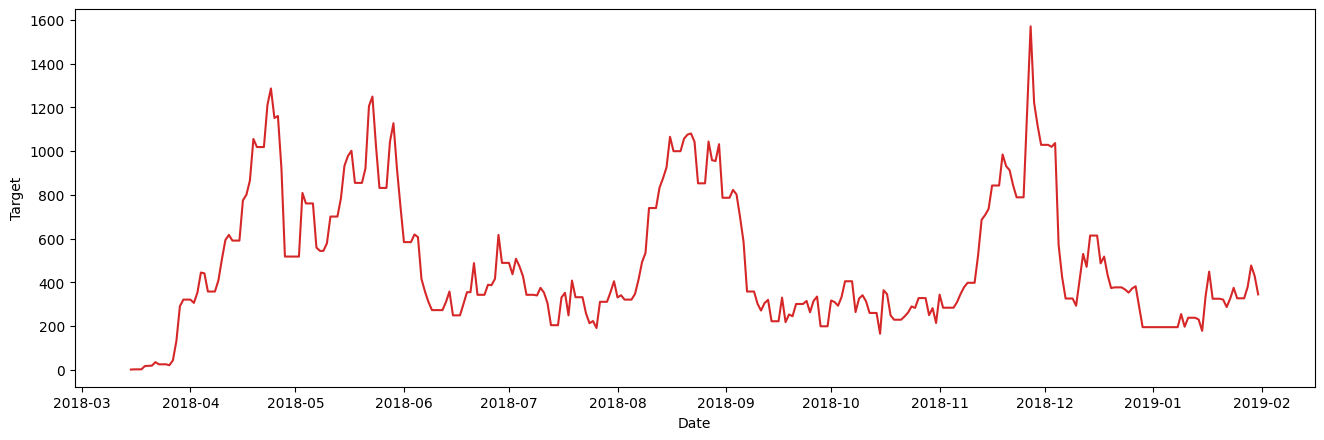

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Target', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.target) 

Видимого тренда не наблюдается. Но позже на всякий случай проверим тестом.


А пока окинем взглядом распределение данных

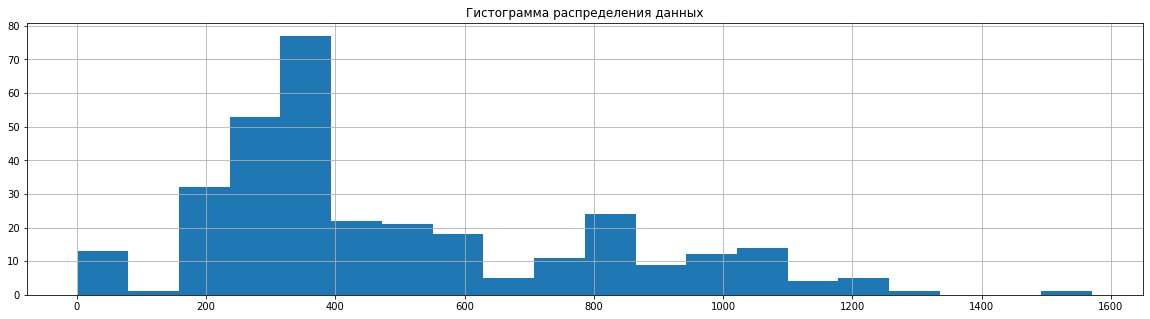

In [ ]:
plt.title('Гистограмма распределения данных')

series = df.target
series.hist(bins=20, figsize = (20,5))
plt.show()

Данные представляют из себя двухмодальное распредение. Первая компонента -- купол с модой ~ 350 и стандартным отклонением ~150, вторая -- довольно пологий купол, "размазанный" по промежутку от 800 до 1100. 
То есть данные гетероскедастичные. Причем дисперсия меняется не монотонно и мы это покажем более явно дальше.


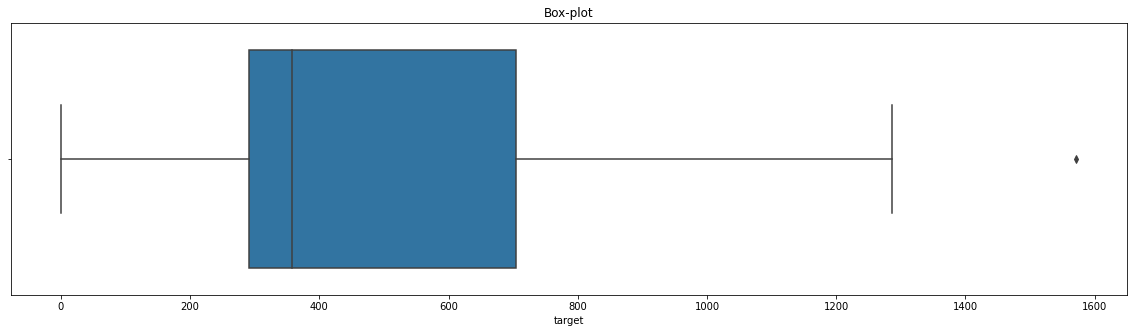

In [ ]:
import seaborn as sns

fig = plt.subplots(figsize=(20, 5))
ax = sns.boxplot(x=series,whis=1.5)
ax.set_title('Box-plot')
plt.show()

Выбросов не так много (один, и тот в декабре перед самым Новым Годом)

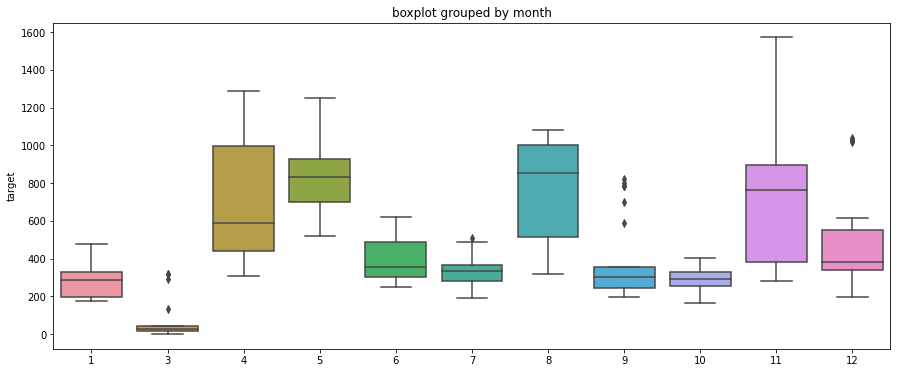

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title('boxplot grouped by month')
sns.boxplot(df.index.month, df.target, ax=ax)
plt.show()

Монотонного изменения статистик (медианы, разброса и т.д.) по месяцам не наблюдается. Выбросы есть в марте, сентябре и декабре

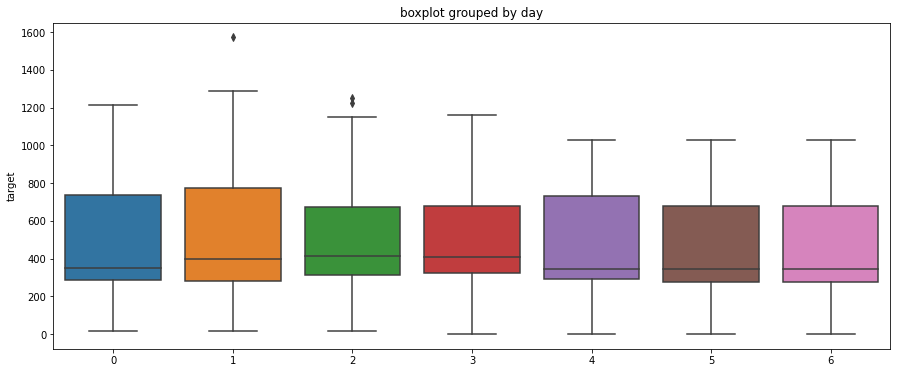

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plt.title('boxplot grouped by day')
sns.boxplot(df.index.dayofweek, df.target, ax=ax)
plt.show()

Проанализировав boxplot по дням недели, можно заметить, что  статистики выглядят достаточно похожими. Нет явной зависимости данных от дня недели

# Исследуем на стационарность
## Компоненты временного ряда

Так как данные представлены всего за 1 год, в качестве сезонного периода есть смысл выбрать месяц или неделю. На графике динамики временного ряда не наблюдается никакого явного повторяющегося паттерна по месяцам. Попробуем выбрать сезонный период в 7 дней.

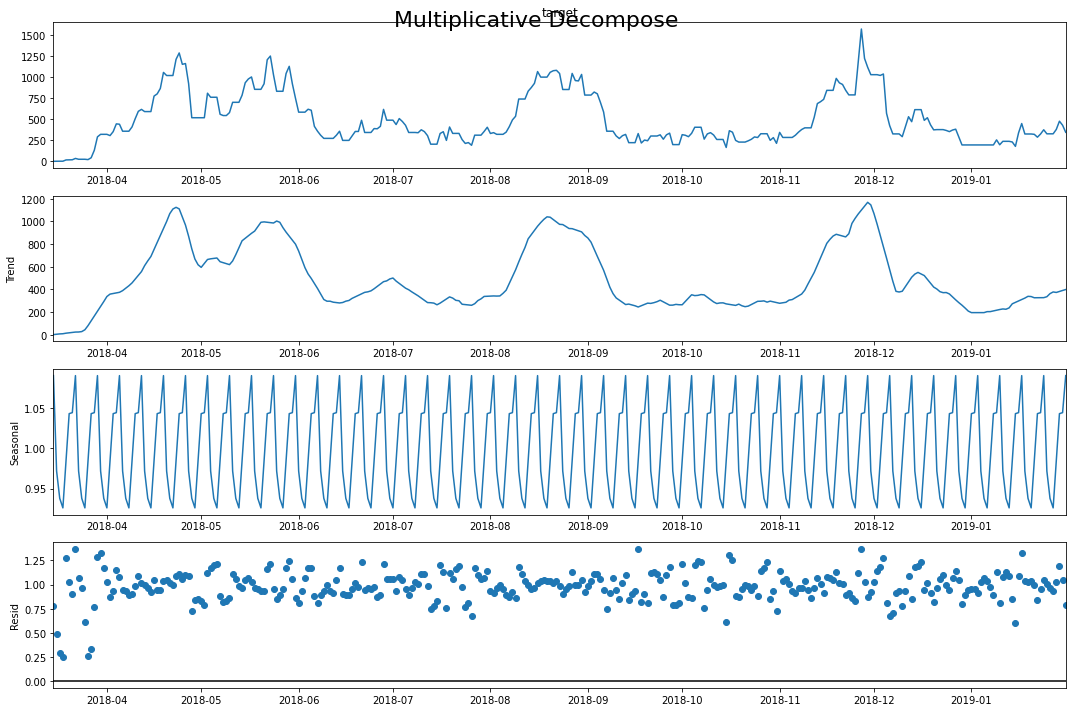

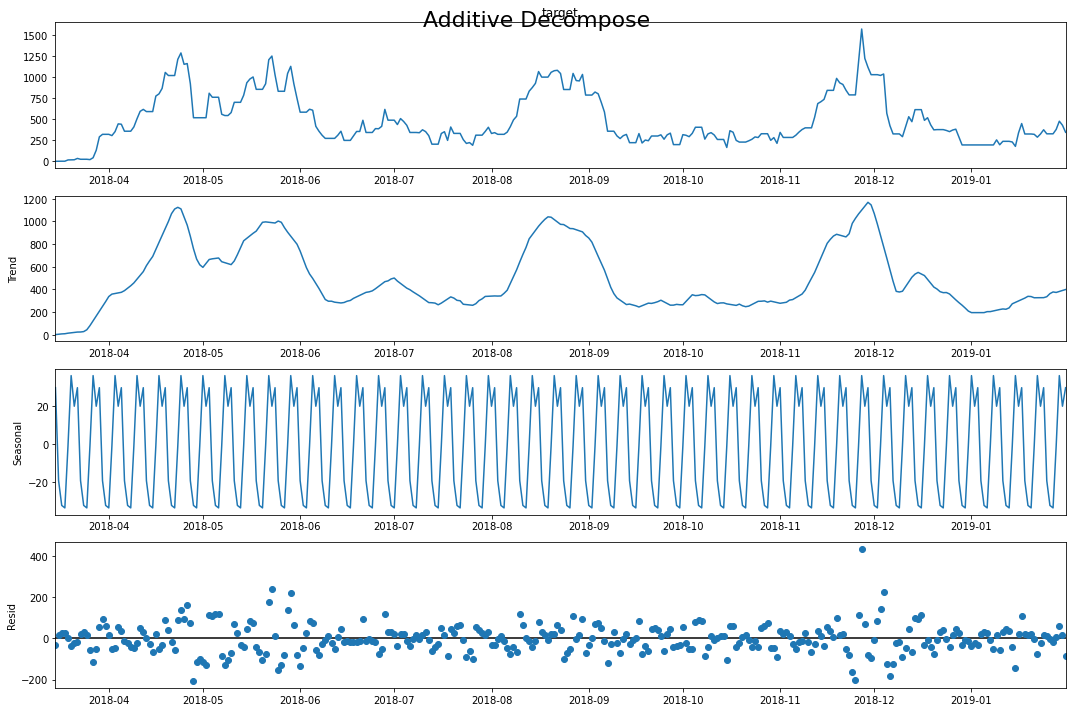

In [ ]:
result_mul = seasonal_decompose(series, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(series, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (15,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

Остатки аддитивной выглядят более случайными, но будто бы недостаточно случаными :)

То есть декомпозиция не дообъясняет данные. Попробуем проверить это при помощи теста остатков на нормальность их распределения.


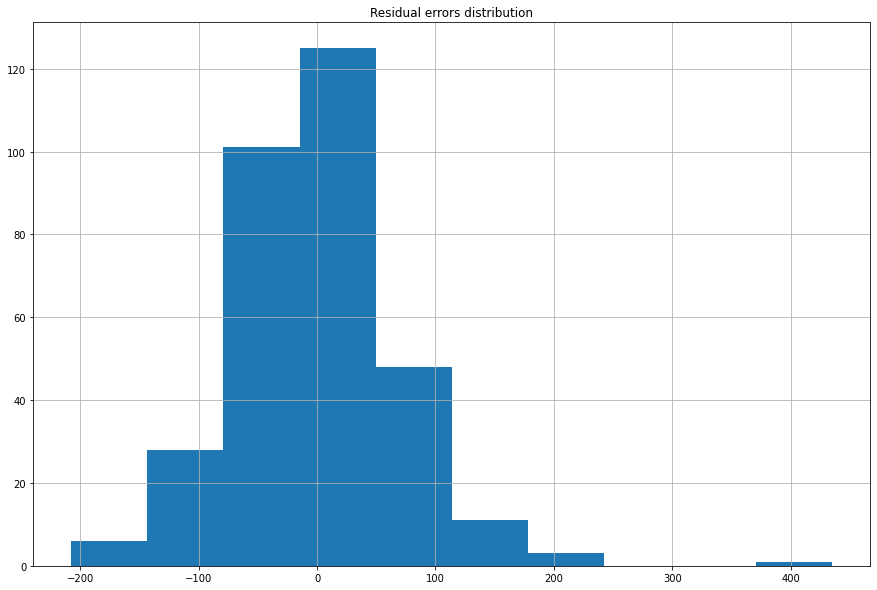

In [ ]:
# Визуальная проверка на нормальность
residuals = pd.DataFrame(result_add.resid)
residuals.hist()
plt.title('Residual errors distribution')
plt.show()

Сделаем тест Шапиро на проверку нормальности распределения ошибки

In [ ]:
stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.954, p=0.000


Гипотеза о нормальности отвергается. То есть раскладывая по компонентам, остается много необъяснённых данных в остатке. Может быть мы неправильно подобрали сезонный период?

Построим график ACF и посмотрим, нет ли там подсказок.

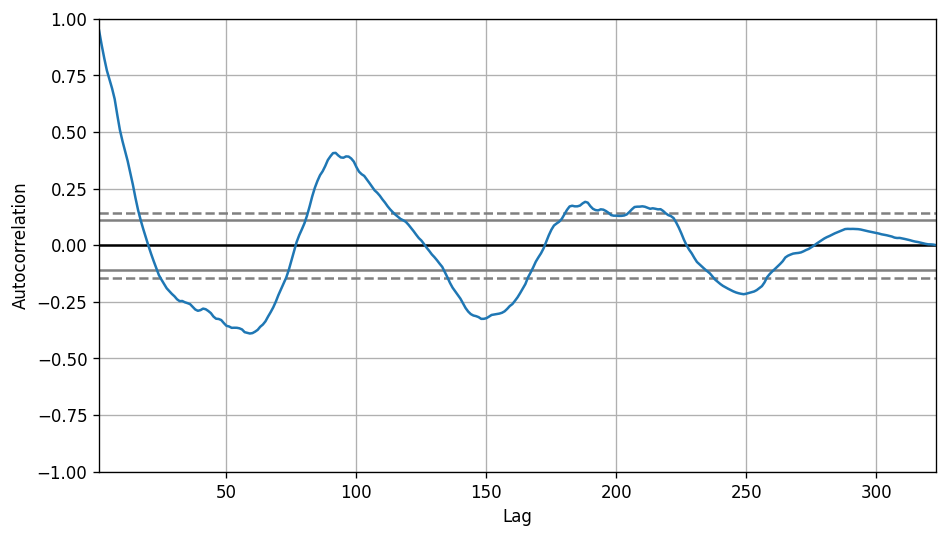

In [ ]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(list(series));

Явных заострений в графике ACF нет, есть небольшие пики (не очень точёные) на лагах, кратных 30, но, кажется, ими можно пренебречь.

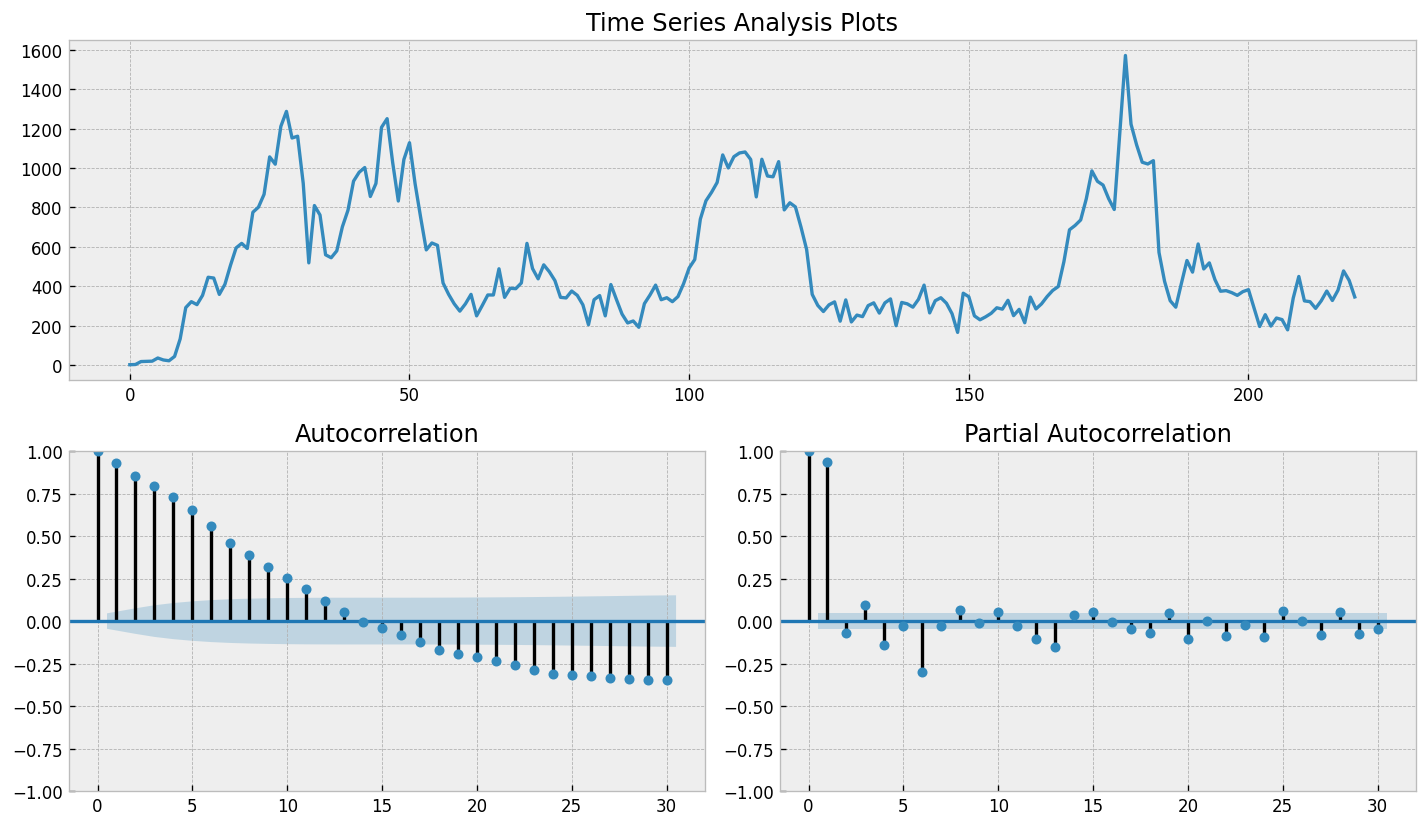

In [ ]:
import statsmodels.tsa.api as smt
import numpy as np

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)


        plt.tight_layout()
    return 

tsplot(np.squeeze(df.values), lags=30)

По графику ACF PACF видно, что есть сильная корреляция между текущим и предыдущим значением. Попробуем от неё избавиться и посмотрим на график снова

In [ ]:
df.head(10)

,target
2018-03-15,1.0
2018-03-16,2.0
2018-03-17,2.0
2018-03-18,2.0
2018-03-19,17.0
2018-03-20,18.0
2018-03-21,19.0
2018-03-22,35.0
2018-03-23,25.0
2018-03-24,25.0


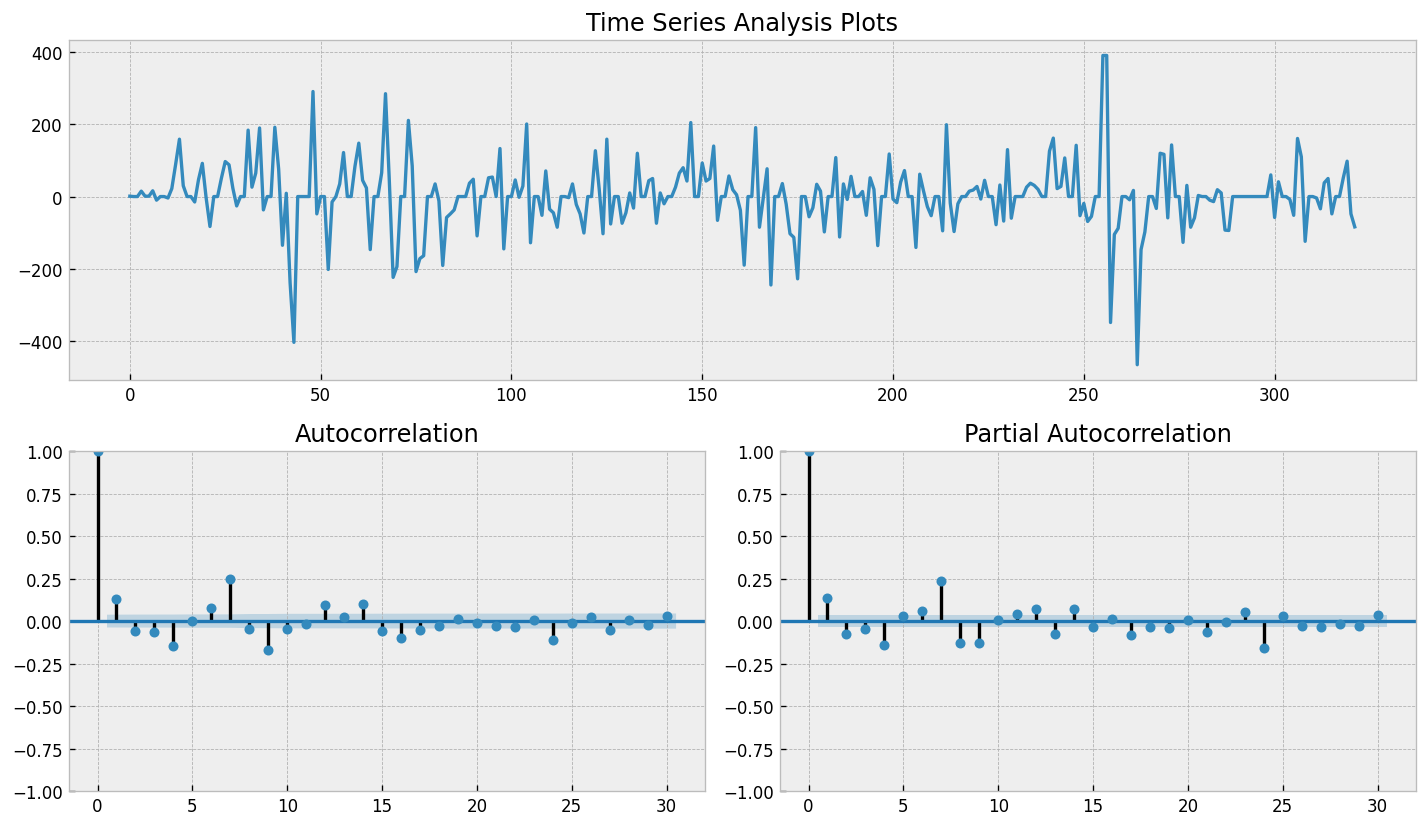

In [ ]:
from scipy.stats import boxcox
# df['target_bc'] = boxcox(series, lmbda=0)
df['target_diff'] = series - series.shift(1)

# При избавлении от сезонности, корелляция между t и t-7 ставновится выше по модулю (0.25  ->  -0.4)
# df['target_diff'] = df['target_diff'] - df['target_diff'].shift(7) 

df.dropna(inplace=True)

tsplot(np.squeeze(df.drop(['target'], 1).values), lags=30)

На графике ACF количество значений, сильно отличных от 0 равно 8. (можно попробовать 4 или 8 в качестве параметра q в модели MA(q))

На PACF наибольший коррелляционный коэффициент находится на 24м лаге, что можно использовать в качестве параметра p в модели AR(p)



In [ ]:
# def remove_seasonality(df, col='target_diff', T=7):
#     for i in range(T, len(df)):
# 	df['target_diff'] = df['target_diff'][i] - df['target_diff'][i - T]
#     return df
# df = remove_seasonality(df)

## Подведём итоги нашего анализа

Мы показали, что у данного ряда
* есть корреляция между $y_t$ и $y_{t-1}$, от которой мы избавились дифференцированием
* сезонности нет или она слабо выражена
* монотонного изменения дисперсии также не отмечено (по графику и по boxplot-у по месяцам)

Сделаем статистический тест, чтобы подтвердить или опровергнуть наше предположение.



### Проверка стационарности:

Dickey Fuller test (ADH Test) - тест Дикки Фуллера, нулевая гипотеза о нестационарности ряда. Если p значение меньше уровня значимости(0.05) - гипотеза отклоняется в пользу альтернативы.

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = list(df.target_diff)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.266068
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


Критерий Дики-Фуллера отвергает нулевую гипотезу о нестационарности. Считаем ряд стационарным.

# Авторегрессионные модели

Сначала разделим данные на train и test, чтобы мы могли сравнивать качества различных моделей. Для test отложим данные за последний месяц. Декабрь в качестве теста брать опасно, так как метрики на нём будут непоказательные (в декабре данные нетипичные для данного распределения, есть выбросы)

In [ ]:
test_idx = df.index.month.isin({1})
train = df.target_diff[~test_idx]
test = df.target_diff[test_idx]

train_init = df.target[~test_idx]
test_init = df.target[test_idx]

## AR

In [ ]:
rmse = lambda yr, yp: np.sqrt(mean_squared_error(yr, yp)).round(2)
mape = lambda yr, yp: np.round(np.mean(np.abs(yr-yp)/yr), 2)


res = pd.DataFrame(columns=['method', 'RMSE', 'MAPE'])

def predict(model, data=df.target):
    y_pred = model.forecast(len(data))
    # y_pred = model.predict(data.index.min(), data.index.max())
    y_pred = y_pred.cumsum()
    y_pred = y_pred.add(data[0])
    # y_pred = np.exp(y_pred)
    return y_pred

def add_results(y_real, y_pred, name):
    global res
    d = {'method' : name, 'RMSE' : rmse(y_real, y_pred), 'MAPE' : mape(y_real, y_pred)}
    res = res.append(d, ignore_index=True)

def visualise(model, name='Auto Regression'):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(train_init, label='Train')
    plt.plot(test_init, label='Test')
    plt.plot(predict(model, test_init), label=name + ' forecast')
    plt.legend(loc='best')
    plt.title(name + ' Method')
    plt.show()
    add_results(test_init, predict(model, test_init), name)
    print(res)

In [ ]:
params = (24, 0, 0)
model_ar = ARIMA(train, order=params) 
model_ar = model_ar.fit()
print(model_ar.params)

const        0.670607
ar.L1        0.163031
ar.L2       -0.015856
ar.L3        0.012991
ar.L4       -0.179081
ar.L5        0.008583
ar.L6        0.062681
ar.L7        0.216798
ar.L8       -0.128216
ar.L9       -0.163939
ar.L10       0.077849
ar.L11       0.026347
ar.L12       0.058540
ar.L13      -0.121472
ar.L14       0.124463
ar.L15      -0.036503
ar.L16      -0.020346
ar.L17      -0.067995
ar.L18      -0.014469
ar.L19       0.004059
ar.L20      -0.018415
ar.L21      -0.080522
ar.L22      -0.016685
ar.L23       0.101914
ar.L24      -0.157067
sigma2    7343.786079
dtype: float64


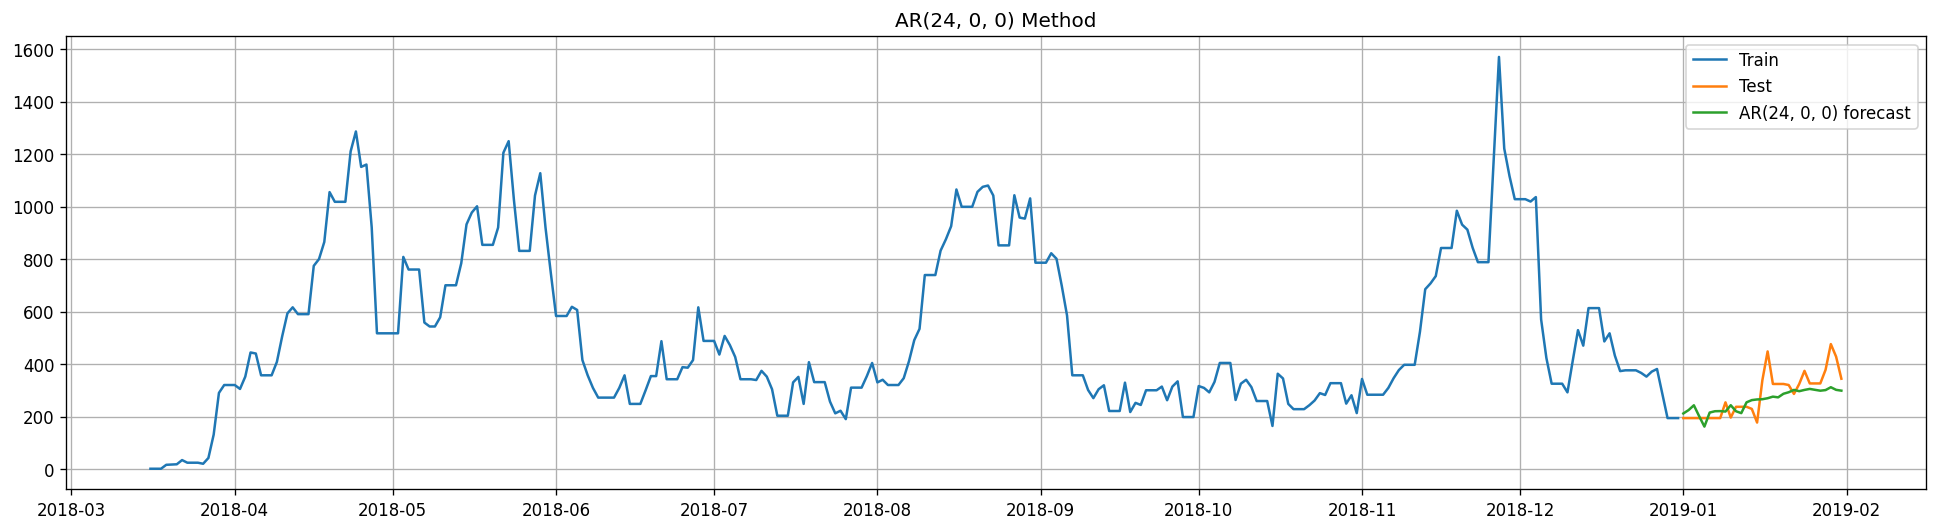

         method   RMSE  MAPE
0  AR(24, 0, 0)  63.06  0.16


In [ ]:
visualise(model=model_ar, name='AR' + str(params))

## MA

const        0.706296
ma.L1        0.137947
ma.L2       -0.036825
ma.L3        0.025144
ma.L4       -0.152106
sigma2    8718.893521
dtype: float64


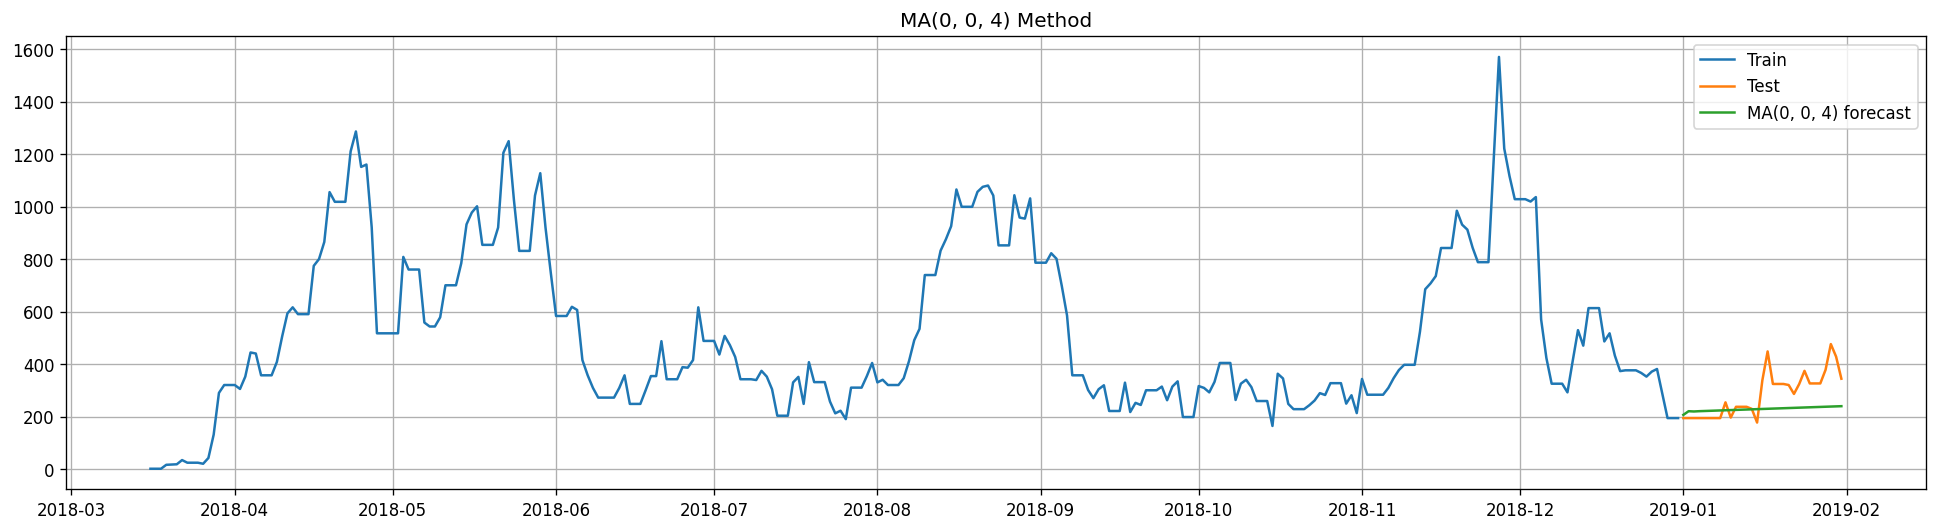

         method   RMSE  MAPE
0  AR(24, 0, 0)  63.06  0.16
1   MA(0, 0, 4)  95.31  0.22


In [ ]:
params = (0, 0, 4)
model_ma = ARIMA(train, order=params) 
model_ma = model_ma.fit()
print(model_ma.params)
visualise(model_ma, 'MA' + str(params))

const        0.674179
ma.L1        0.136859
ma.L2        0.039993
ma.L3        0.008553
ma.L4       -0.169175
ma.L5       -0.083754
ma.L6        0.060253
ma.L7        0.223577
ma.L8       -0.012787
sigma2    8150.156469
dtype: float64


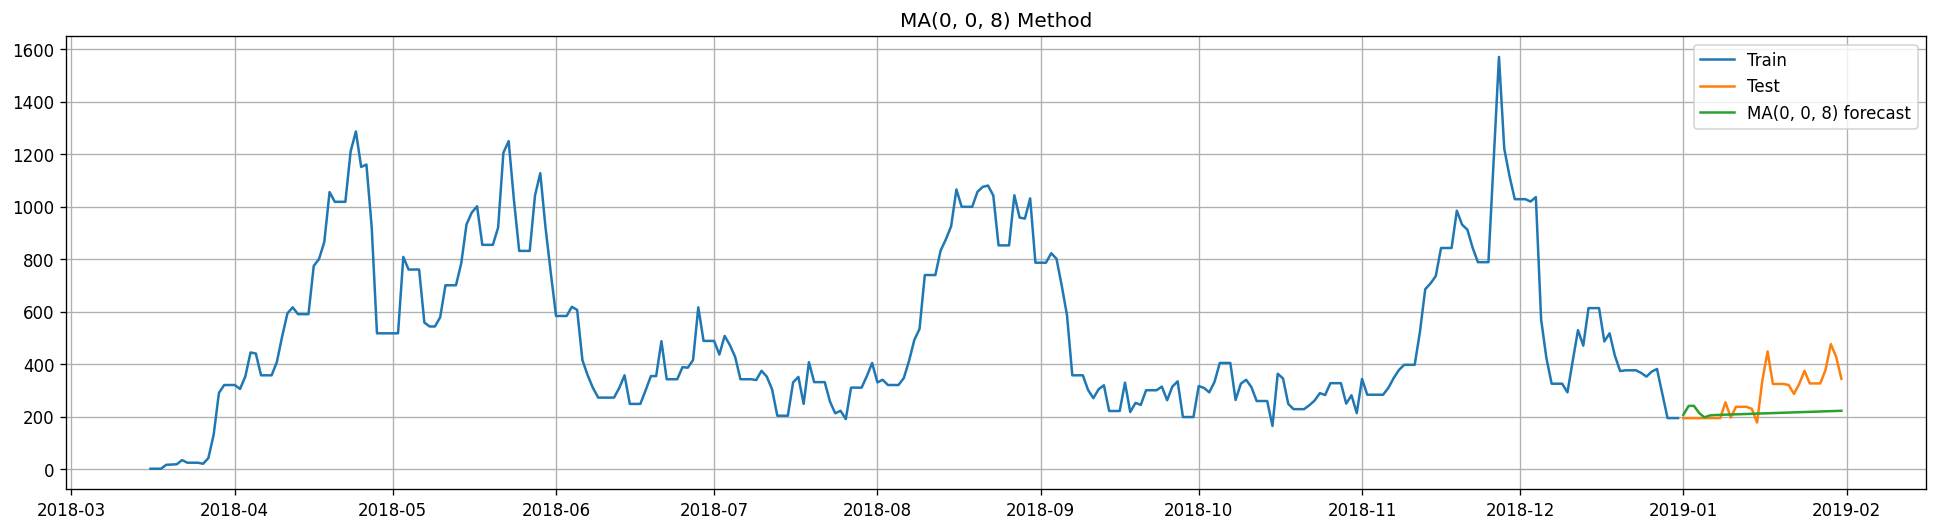

         method    RMSE  MAPE
0  AR(24, 0, 0)   63.06  0.16
1   MA(0, 0, 4)   95.31  0.22
2   MA(0, 0, 8)  106.91  0.25


In [ ]:
params = (0, 0, 8)
model_ma = ARIMA(train, order=params) 
model_ma = model_ma.fit()
print(model_ma.params)
visualise(model_ma, 'MA' + str(params))

## ARMA

In [ ]:
params = (24, 1, 8)
model_arma = ARIMA(df.target[~test_idx], order=params) 
model_arma = model_arma.fit()
print(model_arma.params)

ar.L1       -0.232722
ar.L2       -0.207031
ar.L3        0.028822
ar.L4       -0.178224
ar.L5        0.003885
ar.L6        0.273933
ar.L7        0.450584
ar.L8        0.672582
ar.L9       -0.268613
ar.L10       0.015062
ar.L11       0.036263
ar.L12       0.179884
ar.L13      -0.142509
ar.L14       0.018815
ar.L15      -0.127589
ar.L16       0.104724
ar.L17       0.010193
ar.L18      -0.128430
ar.L19      -0.060811
ar.L20      -0.099842
ar.L21      -0.011739
ar.L22      -0.067334
ar.L23       0.096953
ar.L24      -0.080739
ma.L1        0.375009
ma.L2        0.232876
ma.L3       -0.034838
ma.L4       -0.025966
ma.L5       -0.120482
ma.L6       -0.304629
ma.L7       -0.282941
ma.L8       -0.827707
sigma2    7896.269913
dtype: float64


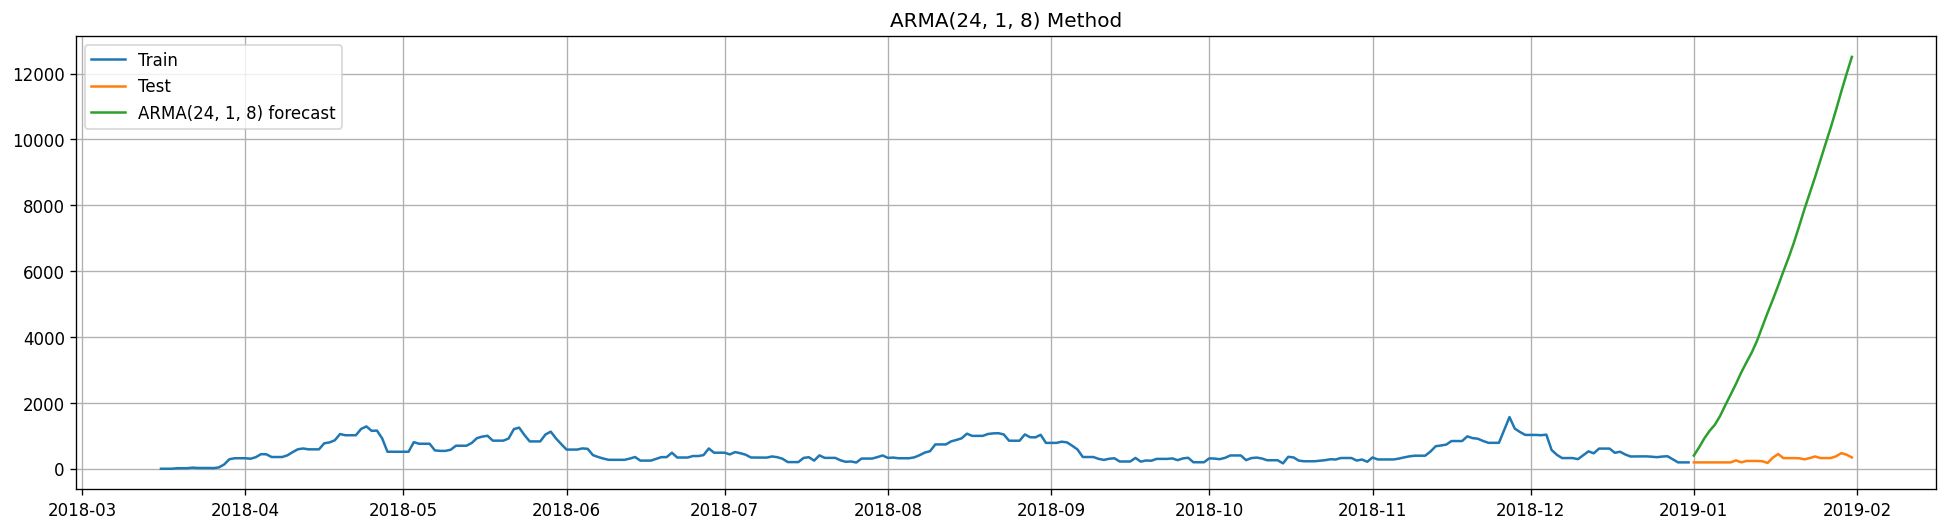

           method     RMSE   MAPE
0    AR(24, 0, 0)    63.06   0.16
1     MA(0, 0, 4)    95.31   0.22
2     MA(0, 0, 8)   106.91   0.25
3  ARMA(24, 1, 8)  6443.62  17.13


In [ ]:
visualise(model_arma, 'ARMA' + str(params))

## SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
params = (0, 1, 1), (0, 1, 1, 7)
model_sarima = SARIMAX(train, order=params[0], seasonal_order=params[1]) 
model_sarima = model_sarima.fit()
print(model_sarima.params)

ma.L1        -0.998995
ma.S.L7      -0.945406
sigma2     8715.124738
dtype: float64


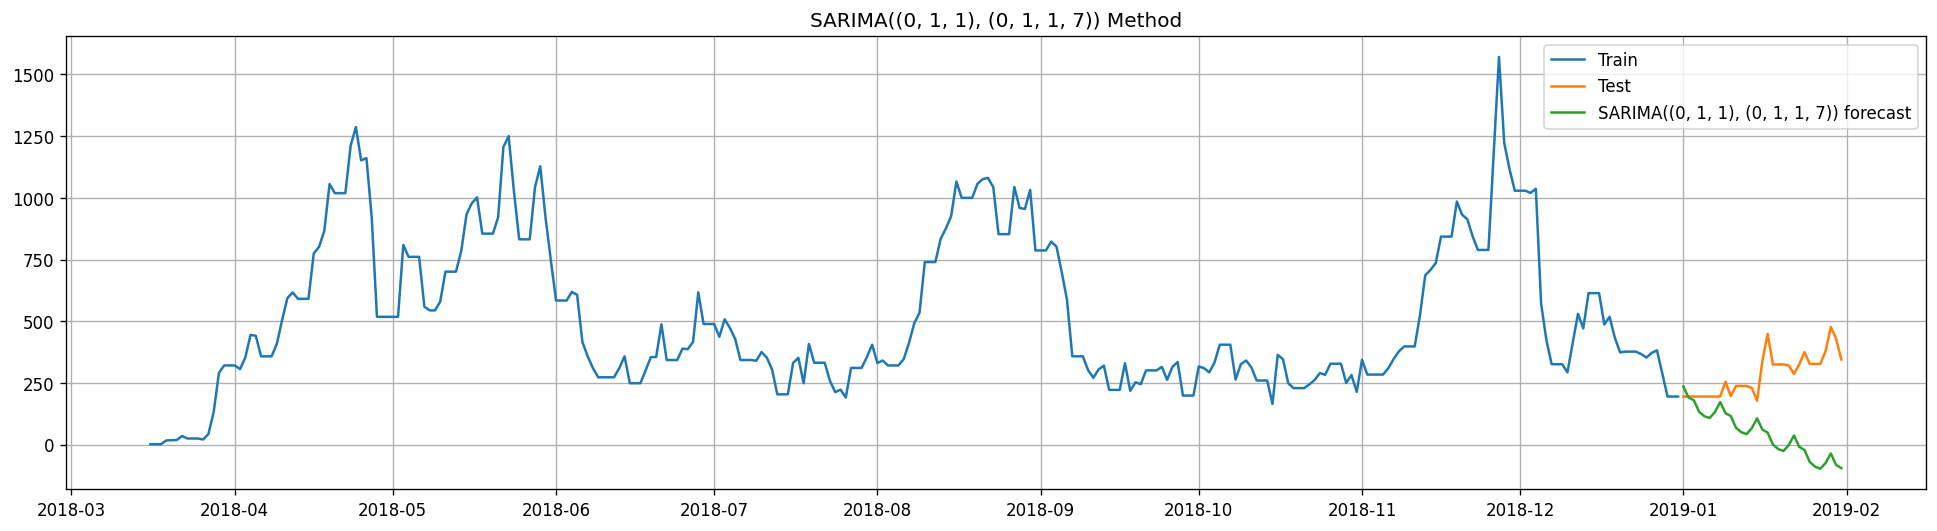

                            method     RMSE   MAPE
0                     AR(24, 0, 0)    63.06   0.16
1                      MA(0, 0, 4)    95.31   0.22
2                      MA(0, 0, 8)   106.91   0.25
3                   ARMA(24, 1, 8)  6443.62  17.13
4  SARIMA((0, 1, 1), (0, 1, 1, 7))   291.38   0.76


In [ ]:
visualise(model_sarima, 'SARIMA' + str(params))

Результаты предсказаний протестированных моделей на тестовой выборке выглядят вот так:

In [ ]:
res

,method,RMSE,MAPE
0,"AR(24, 0, 0)",63.06,0.16
1,"MA(0, 0, 4)",95.31,0.22
2,"MA(0, 0, 8)",106.91,0.25
3,"ARMA(24, 1, 8)",6443.62,17.13
4,"SARIMA((0, 1, 1), (0, 1, 1, 7))",291.38,0.76


лучше всего сработала модель AR(24). Посмотрим на остатки

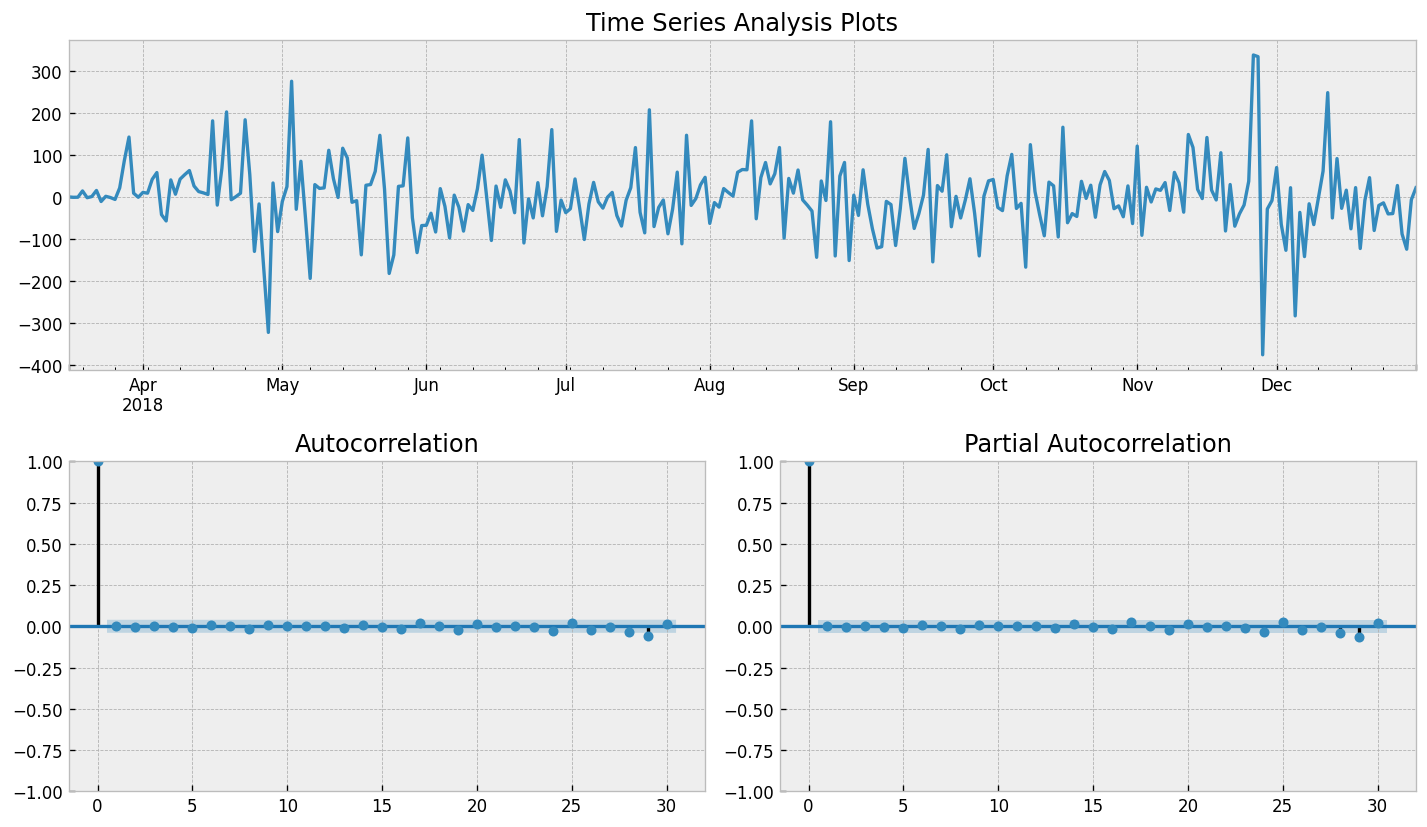

In [ ]:
tsplot(model_ar.resid, lags=30)

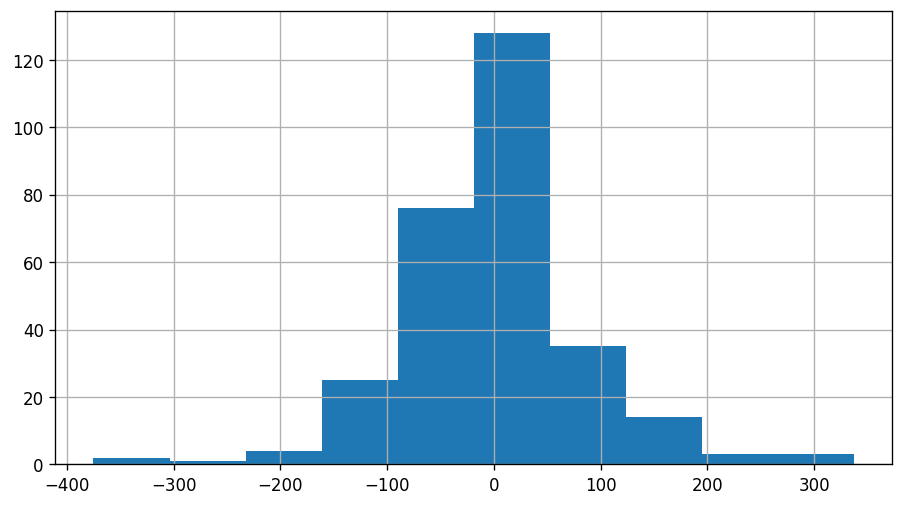

In [ ]:
model_ar.resid.hist();

In [ ]:
stat, p = shapiro(model_ar.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.948, p=0.000


В остатках почти нет автокорреляции, но распределение у них не является нормальным. Подберём модель перебором

In [ ]:
df = pd.read_csv(filename, parse_dates=['date'], index_col='date')

returns = df.target.pct_change().dropna()

test_idx = df.index.month.isin({1})
ret_idx = returns.index.month.isin({1})

train, train_ret = df.target[~test_idx], returns[~ret_idx]
test, test_ret = df.target[test_idx], returns[ret_idx]

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = [0,1,2,3,4, 8] # [0,1,2,3,4]
    d_rng = [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = ARIMA(TS, order=(i,d,j), trend='n')
                    tmp_mdl = tmp_mdl.fit(method='innovations_mle')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: 
                    continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic: 2479.34832 | order: (2, 1, 8)


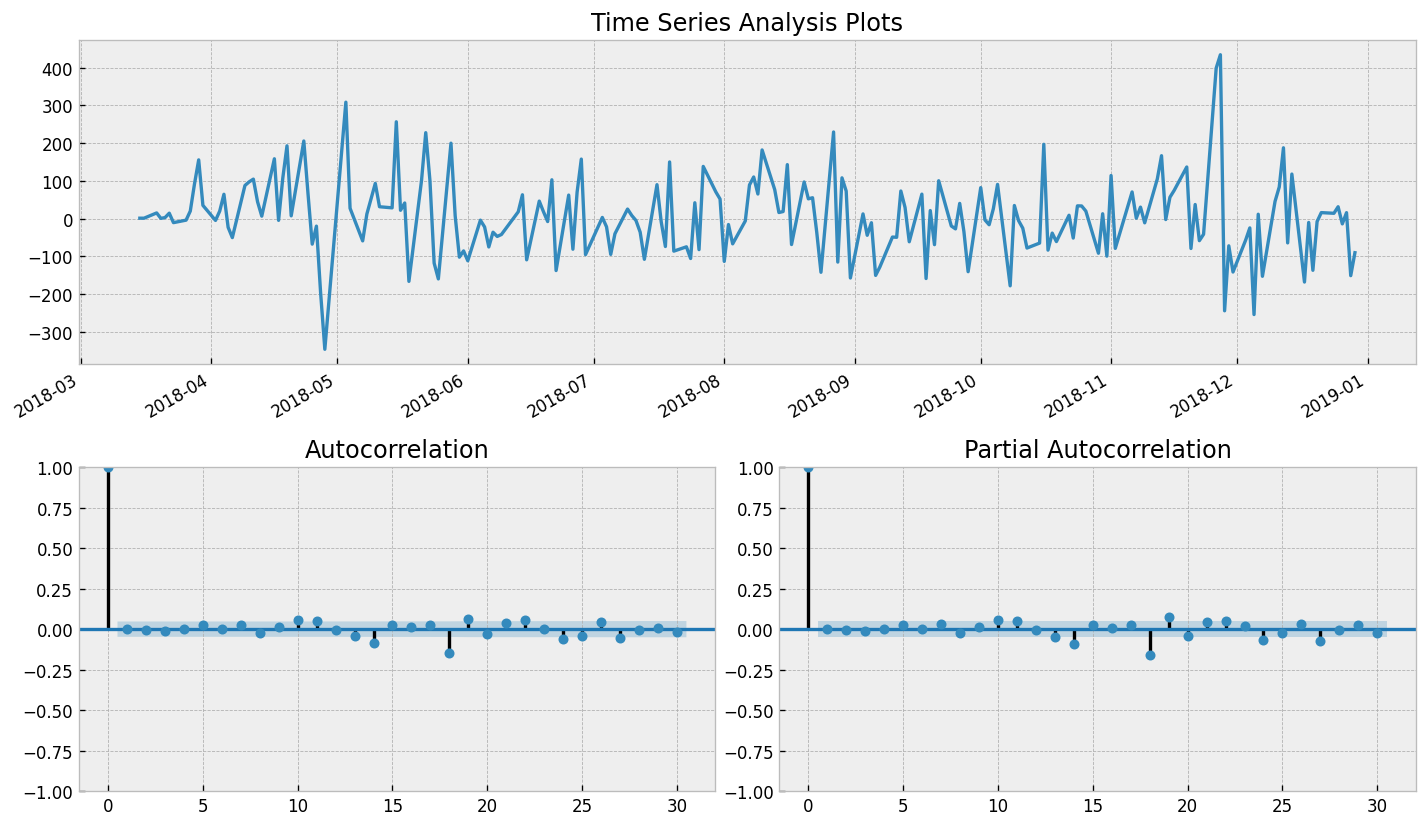

In [ ]:
aic, order, model = _get_best_model(train)
tsplot(model.resid, lags=30)

In [ ]:
# visualise(model, name='ARIMA (2, 1, 8)')

## Работаем с доходностями
Попробуем теперь подобрать параметры не к самим данным, а к доходностям

In [ ]:
aic, order, model = _get_best_model(returns)

aic: 344.71485 | order: (0, 1, 8)


In [ ]:
p = model.get_prediction(test.index[0])
p.prediction_results

## ARCH

Так как данные на разных участках имеют разную дисперсию, линейных моделей недостаточно. Применим ARCH  к остаткам ARIMA(0, 1, 8)

In [ ]:
from arch import arch_model

resid = model.resid

split_date=train.index[-1]
model_arch = arch_model(resid, p=0, o=1, q=8, dist='StudentsT')

res_arch = model_arch.fit(last_obs=split_date, disp='off')
res_arch

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -62.1301
Distribution:      Standardized Student's t   AIC:                           148.260
Method:                  Maximum Likelihood   BIC:                           187.900
                                              No. Observations:                  201
Date:                      Sun, Mar 13 2022   Df Residuals:                      200
Time:                              20:41:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

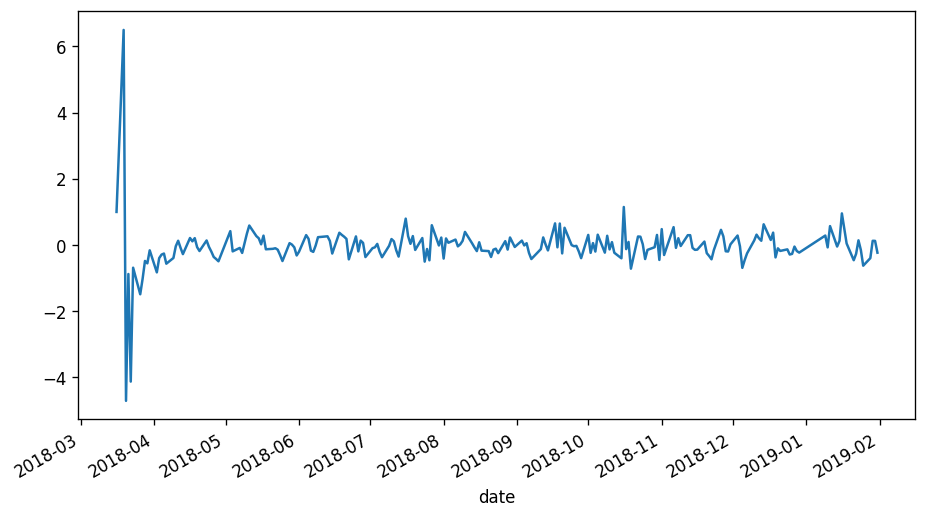

In [ ]:
resid.plot();

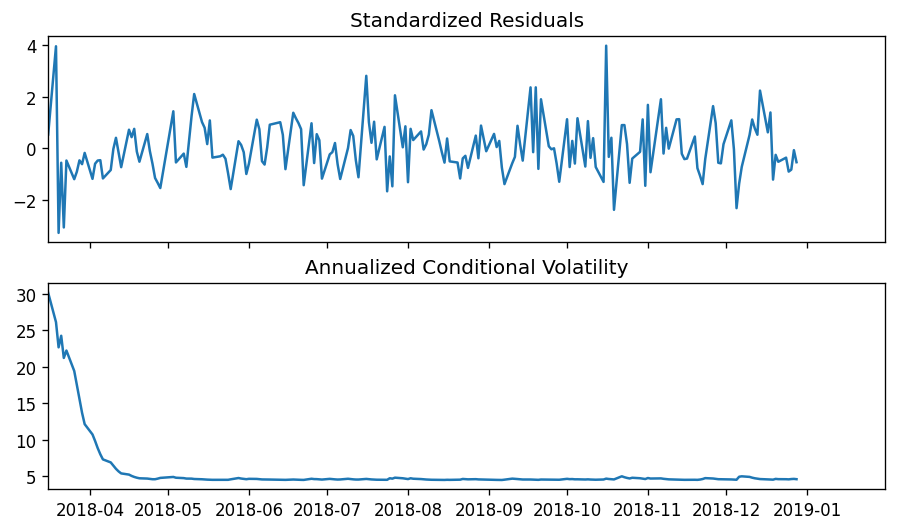

In [ ]:
fig = res_arch.plot(annualize='D')

In [ ]:
res_arch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -62.1301
Distribution:      Standardized Student's t   AIC:                           148.260
Method:                  Maximum Likelihood   BIC:                           187.900
                                              No. Observations:                  201
Date:                      Sun, Mar 13 2022   Df Residuals:                      200
Time:                              20:41:41   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0276  2.300e-02     -1.200      0.230 [-7.268e-02,1.749e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0204  3.559e-02      0.572      0.567 [-4.940e-02,9.011e-02]
gamma[1]       0.0363      0.818  4.431e-02      0.965      [ -1.568,  1.640]
beta[1]        0.7455      4.583      0.163      0.871      [ -8.236,  9.727]
beta[2]        0.0000      9.418      0.000      1.000      [-18.460, 18.460]
beta[3]        0.0000      2.322      0.000      1.000      [ -4.550,  4.550]
beta[4]        0.0000      5.855      0.000      1.000      [-11.475, 11.475]
beta[5]        0.0000      2.449      0.000      1.000      [ -4.800,  4.800]
beta[6]        0.0000      3.916      0.000      1.000      [ -7.676,  7.676]
beta[7]        0.0000      0.999      0.000      1.000      [ -1.958,  1.958]
beta[8]        0.0000      0.747      0.000      1.000      [ -1.465,  1.465]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             7.4784      6.184      1.209      0.227 [ -4.642, 19.599]
========================================================================

Covariance estimator: robust
"""

In [ ]:
forecasts = res_arch.forecast(horizon=5, start=split_date) 
forecasts.variance.tail()

,h.1,h.2,h.3,h.4,h.5
date,,,,,
2019-01-25,0.096374,0.093953,0.092105,0.090693,0.089615
2019-01-28,0.097150,0.094546,0.092557,0.091039,0.089879
2019-01-29,0.092784,0.091212,0.090012,0.089095,0.088394
2019-01-30,0.089530,0.088727,0.088113,0.087645,0.087288
2019-01-31,0.088614,0.088027,0.087579,0.087237,0.086976


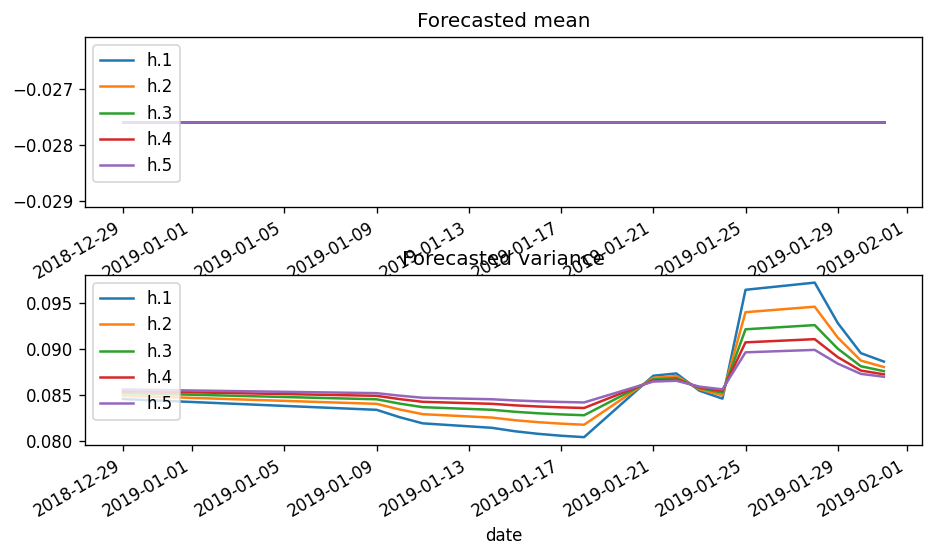

In [ ]:
# среднее прогноза 
forecasts.mean[split_date:].plot(ax=plt.subplot(2, 1, 1));
plt.title('Forecasted mean')

# дисперсия прогноза 
forecasts.variance[split_date:].plot(ax=plt.subplot(2, 1, 2));
plt.title('Forecasted variance')
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.show()

In [ ]:
import datetime as dt

def fit_predict_arch(model_arima=model, train=df.target, period=None, testing=False, test=None):
    # data prep

    resid = model_arima.resid
    # model_arima.fit()

    # fitting

    model_arch = arch_model(resid, p=0, o=1, q=8, dist='StudentsT')
    res_arch = model_arch.fit(last_obs=split_date, disp='off')

    # prediction
    
    if testing:
        results = pd.DataFrame(test)
    else:
        results = pd.DataFrame(index=period)
    vol = np.array(model_arch.simulate(res_arch.params, len(results))['data'])
    pred = []
    pred.append(train.iloc[-1] * (1 + vol[0]))
    for r in vol[1:]:
        pred.append(pred[-1] * (1 + r))
    pred2 = model_arima.forecast(len(results))
    pred = np.array(pred) + np.array(pred2)
    results['prediction'] = pred


    global res
    if testing:
        d = {'method' : 'ARCH', 'RMSE' : rmse(test, pred), 'MAPE' : mape(test, pred)}
        res = res.append(d, ignore_index=True)

    return results

def visualise_arch(train, test_pred, name='ARCH', testing=False):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(train, label='Train')
    if testing:
        plt.plot(test_pred.target, label='Test')
    plt.plot(test_pred.prediction, label=name + ' forecast')
    plt.legend(loc='best')
    plt.title(name + ' Method')
    plt.show()
    print(res)


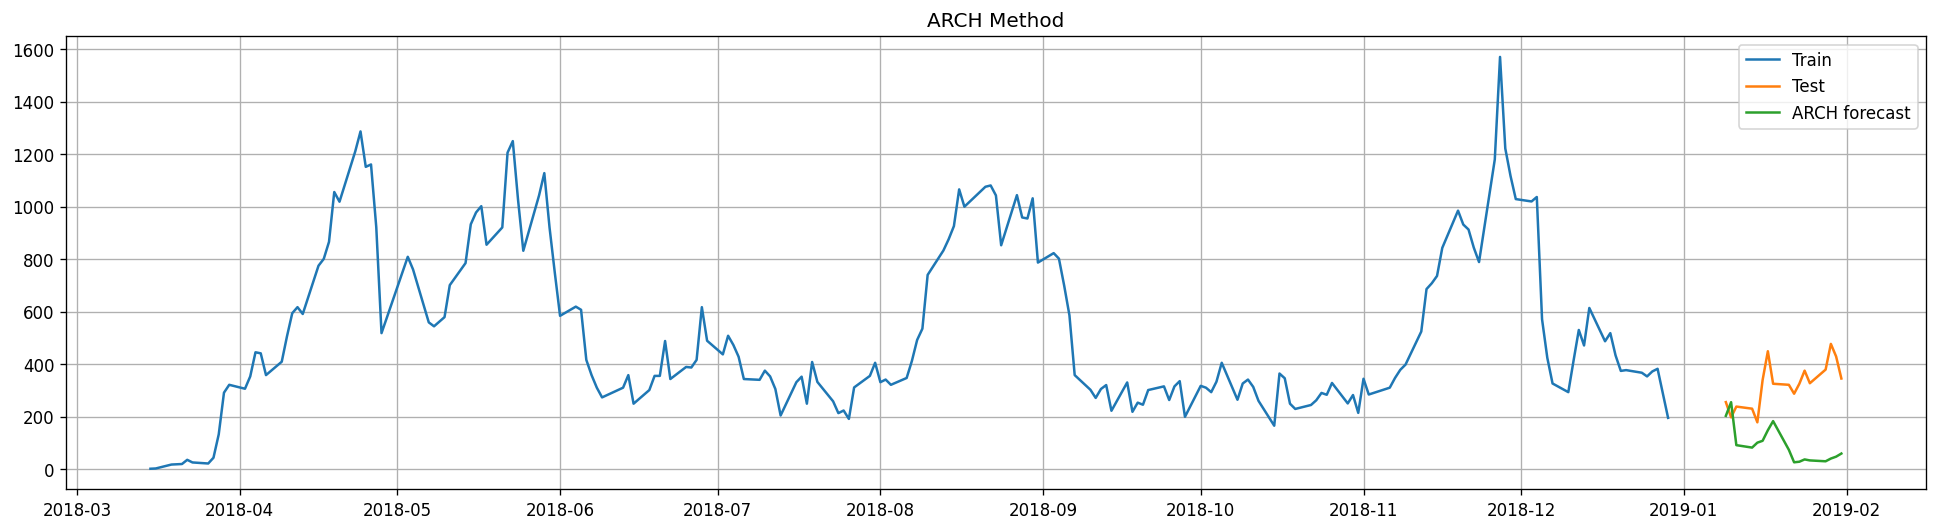

                             method     RMSE   MAPE
0                      AR(24, 0, 0)    63.06   0.16
1                       MA(0, 0, 4)    95.31   0.22
2                       MA(0, 0, 8)   106.91   0.25
3                    ARMA(24, 1, 8)  6443.62  17.13
4   SARIMA((0, 1, 1), (0, 1, 1, 7))   291.38   0.76
5                              ARCH   126.95   0.34
6                              ARCH   153.57   0.40
7                              ARCH   183.34   0.48
8                              ARCH   123.80   0.35
9                              ARCH   123.30   0.28
10                             ARCH   257.98   0.68
11                             ARCH   263.54   0.70


In [ ]:
test_pred = fit_predict_arch(model, train, testing=True, test=test)
visualise_arch(train, test_pred, testing=True)

# Предсказание

Теперь предскажем на февраль (обучившись на всех данных). Надо предсказать 19 следующих значений

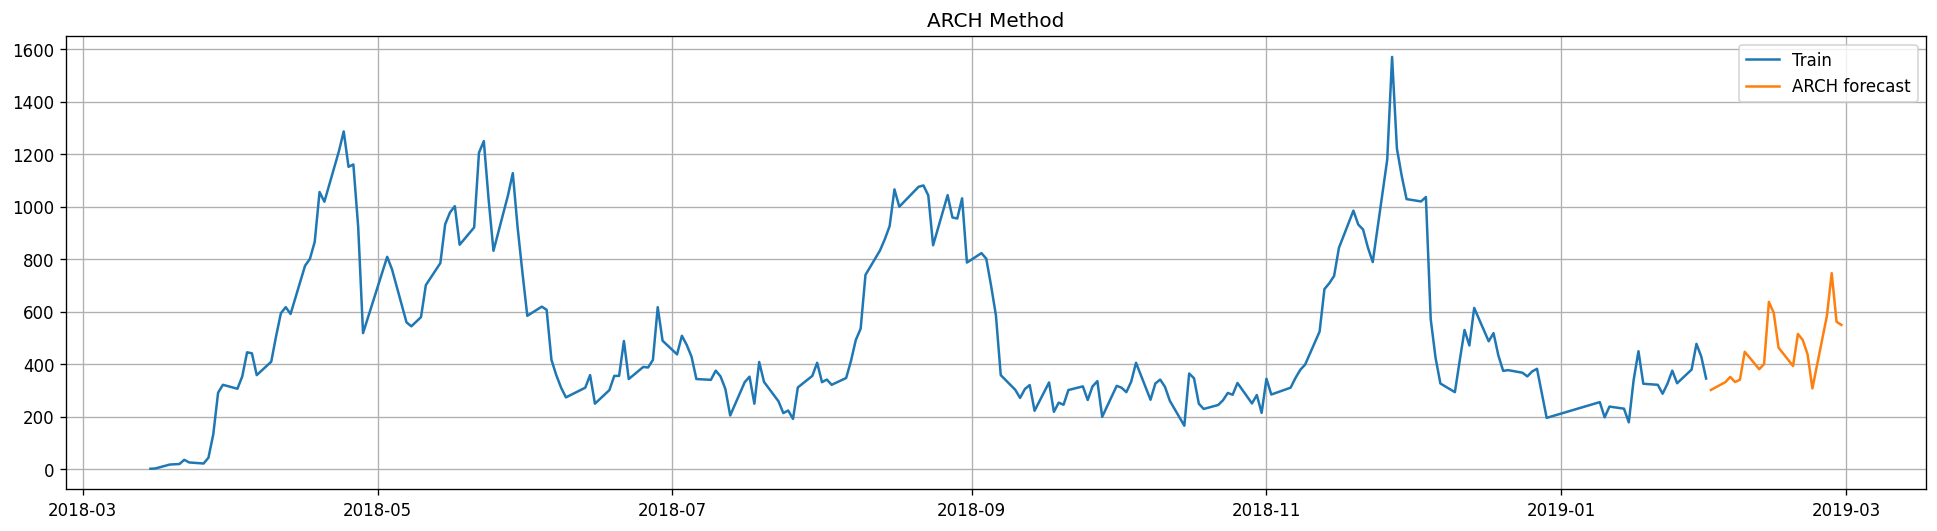

                            method     RMSE   MAPE
0                     AR(24, 0, 0)    63.06   0.16
1                      MA(0, 0, 4)    95.31   0.22
2                      MA(0, 0, 8)   106.91   0.25
3                   ARMA(24, 1, 8)  6443.62  17.13
4  SARIMA((0, 1, 1), (0, 1, 1, 7))   291.38   0.76
5                             ARCH   126.95   0.34
6                             ARCH   153.57   0.40
7                             ARCH   183.34   0.48
8                             ARCH   123.80   0.35
9                             ARCH   123.30   0.28


In [ ]:
import datetime as dt
feb = pd.date_range(dt.date(2019, 2, 1), dt.date(2019, 2, 28), freq='B')

test_pred = fit_predict_arch(model_arima=model, train=df.target, period=feb)
visualise_arch(df.target, test_pred)